In [1]:
%matplotlib inline

import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns

### Data  Description
I have used the WISDM-dataset from UCI. This is a collection of raw motion data recorded from a smartwatch and a smartphone's accelerometer and gyrometer. This data was recorded from 51 different users while they performed 18 types of different activities like walking, running, eating

#### Business use cases
This data can be used to track a user's daily habits. 
Every single habit can be tracked for getting valuable insights. We shall start with exploring how different does the motion data look for different activities and users. Once that is clear, it shall become possible to do a lot more.

#### reading in the activity labels

In [2]:
columns = ['Subject-id', 'Activity Code', 'Timestamp', 'x', 'y', 'z']

activities = pd.read_csv('activity_key.txt', header=None)

activities_map = activities.iloc[:,0].str.split(' = ', expand=True).set_index(1).to_dict()[0]

#### reading accelerometer data for 1 user

In [3]:
data = pd.read_csv('raw/watch/accel/data_1600_accel_watch.txt', names=columns)

# mapping the activity labels to this data
data['Activity Code'] = data['Activity Code'].map(activities_map)

data['z'] = data['z'].apply(lambda x : float(x[:-1]))

#### the distribution of data across different activities for this user

In [4]:
data.groupby('Activity Code').count().iloc[:,1]

Activity Code
catch        3605
chips        3605
clapping     3605
dribbling    3605
drinking     3606
folding      4176
jogging      3605
kicking      3605
pasta        3605
sandwich     3605
sitting      3606
soup         3605
stairs       3605
standing     3605
teeth        3604
typing       3605
walking      3605
writing      3605
Name: Timestamp, dtype: int64

### Question 1
How similar or different is this accelrometer data for a user across different activities?

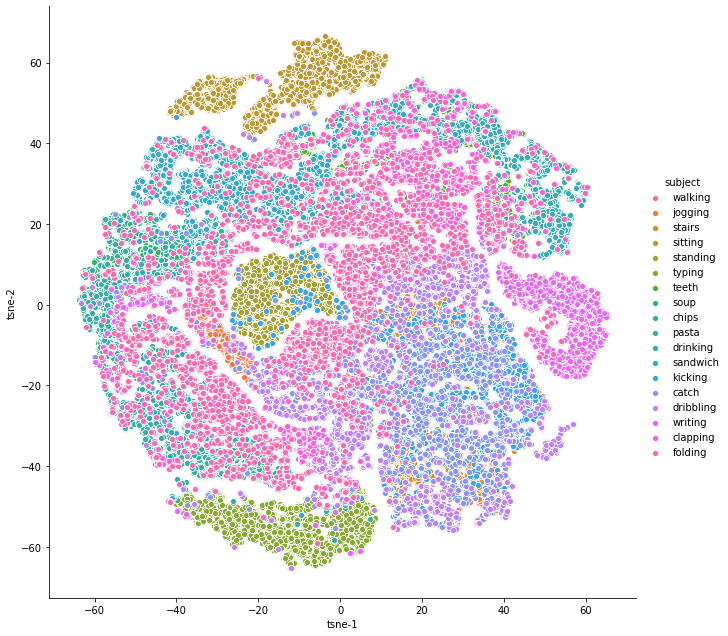

In [5]:
# getting data into 2 dimensions using tSNE
tsne = TSNE(n_components=2)
data_reduced = tsne.fit_transform(data[['x', 'y', 'z']])

# preparing data for visualization
visualize_subjects = pd.DataFrame(data_reduced, columns = ['tsne-1', 'tsne-2'])
visualize_subjects['subject'] = data['Activity Code'].reset_index(drop=True)

# visualize
sns.pairplot(x_vars=["tsne-1"], y_vars=["tsne-2"], data=visualize_subjects, hue="subject", height = 9)

> Different activities do tend to form different clusters. This differentiation shall be enough for us to further build upon our business use cases. It shall be possible to create classifiers that automatically identify what a user is doing and track his habits just from his motion data.

### Question 2
How does the same activity look like for different users? Let us explore this more particularly for the walking patterns across different users.

#### Reading in data for multiple users

In [49]:
# aggregate data for multiple subjects in a single dataframe
df = pd.DataFrame()
for i in range(3):
    data = pd.read_csv('raw/watch/accel/data_160' + str(i) + '_accel_watch.txt', names=columns)
    df = df.append(data)

# clean the data along z axis
df['z'] = df['z'].apply(lambda x : float(x[:-1]))


# get an idea of the distribution of data across different subjects
df['Subject-id'].value_counts()

> So we have around 65k data points for each of the users

#### Observing walking patterns for different users
This is the data with Activity Code = A

In [64]:
walk_data = df.loc[df['Activity Code'] == 'A']
x_acc_walk = walk_data.groupby('Subject-id')['x'].plot(legend=True)

This is an interesting pattern. The user 1601 has a very different style of walking as recorded on the x component of the smartwatch's accelerometer, when compared with the users 1600 and 1602. Let us now also observe the y and z components.

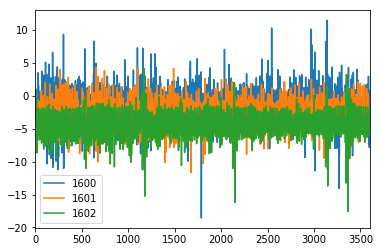

In [66]:
y_acc_walk = walk_data.groupby('Subject-id')['y'].plot(legend=True)

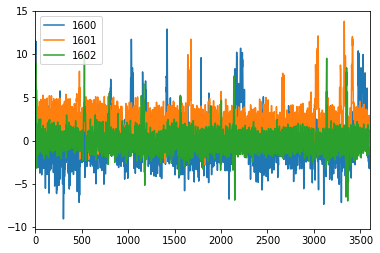

In [67]:
z_acc_walk = walk_data.groupby('Subject-id')['z'].plot(legend=True)

There are subtle differences between different users on y and z axes as well, although not as pronounced as x, it should be possible to utilize these differences to identify diffferent users based on these walking patterns.

### Question 3
Suppose we are interested in tracking what a user is eating. And if he is eating healthy? Let us take a random user and observe how does the motion data differ when he eats different items.

In [6]:
activities_map

{'A': 'walking',
 'B': 'jogging',
 'C': 'stairs',
 'D': 'sitting',
 'E': 'standing',
 'F': 'typing',
 'G': 'teeth',
 'H': 'soup',
 'I': 'chips',
 'J': 'pasta',
 'K': 'drinking',
 'L': 'sandwich',
 'M': 'kicking',
 'O': 'catch',
 'P': 'dribbling',
 'Q': 'writing',
 'R': 'clapping',
 'S': 'folding'}

In [17]:
eating_activites = ['soup', 'chips', 'pasta', 'sandwich']

# read watch accel data for user 1622
data = pd.read_csv('raw/watch/accel/data_1622_accel_watch.txt', names=columns)

# mapping the activity labels to this data
data['Activity'] = data['Activity Code'].map(activities_map)
# cleaning the z component
data['z'] = data['z'].apply(lambda x : float(x[:-1]))

# data preparation
data.drop(['Subject-id', 'Activity Code', 'Timestamp'], axis = 1, inplace=True)
data = data[data['Activity'].isin(eating_activites)]
data.reset_index(drop=True, inplace=True)

#### The variation of different acceleratometer components for different activites

#### x component

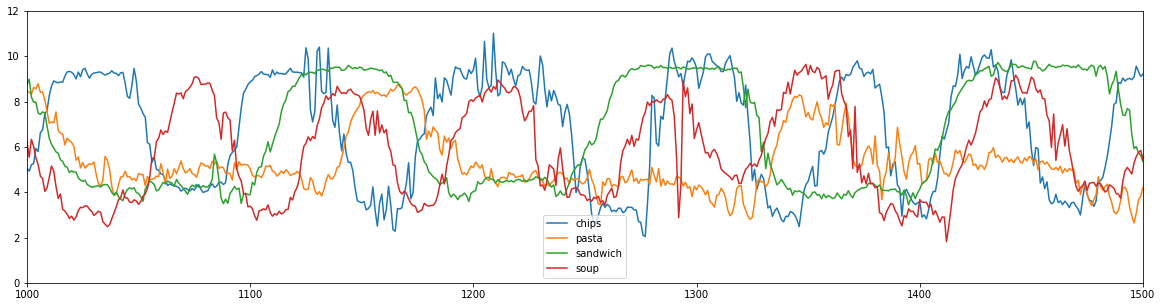

In [87]:
x_comparison = data.groupby('Activity')['x'].plot(legend=True, use_index=False, xlim = (1000,1500), ylim = (0,12), figsize = (20,5))

#### y component

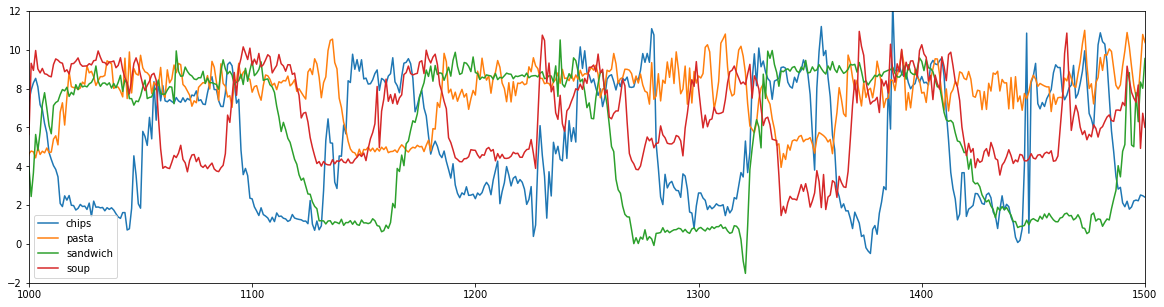

In [88]:
y_comparison = data.groupby('Activity')['y'].plot(legend=True, use_index=False, xlim = (1000,1500), ylim = (-2,12), figsize = (20,5))

#### z component

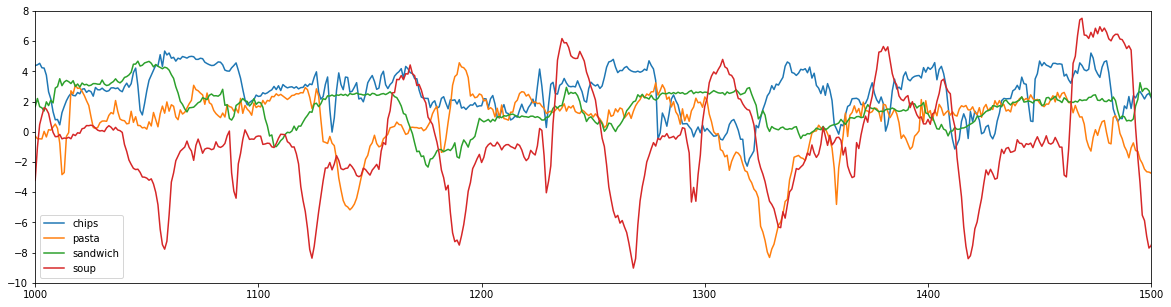

In [89]:
z_comparison = data.groupby('Activity')['z'].plot(legend=True, use_index=False, xlim = (1000,1500), ylim = (-10,8), figsize = (20,5))

> - There is a very rhythmic pattern along the x acceleration component for eating chips, sandwich and soups. Pasta seems to lack such a pattern, probably because in each bite of pasta you might have a different ingredient and a different eating pattern.
- Every pattern has a very different wavelength and amplitude from which it is possible to identify what a person is eating. Especially on combining data from x, y and z components of the accelerometer.